1. Preprocessing
2. Labeling
3. Data Splitting
4. Feature Extraction
5. Modeling
6. Evaluasi
3. Visualization

zsh:1: command not found: pip


In [1]:
import numpy as np
import re
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from collections import Counter

In [2]:
from nltk.corpus import stopwords

In [312]:
df = pd.read_csv('data-stockbit-new.csv')
df

,Date,Content
0,"1 Jan 25, 17:32",SIP PERFORMANCE 2024 Return SIP +12.09% Retur...
1,"1 Jan 25, 14:22",$BBRI $BMRI $ADRO Ada news mantap darimantan...
2,"1 Jan 25, 11:45",Selamat tahun baru.. Semoga semua makhluk berb...
3,"1 Jan 25, 06:57",sebenernya yg naik itu PPN atau PPNBM sih bing...
4,"1 Jan 25, 12:47","$IHSG yakin awal Januari bullish, gua sudah si..."
...,...,...
13598,"31 Mar 25, 18:30",$CLEO wonderful company 😎😎 $BBCA $CPRO
13599,"31 Mar 25, 12:33","Taqabbalallahu minna wa minkum, shiyamana wa s..."
13600,"31 Mar 25, 10:09",Selamat Hari Raya Idul Fitri 2025! 🌙✨ Semoga...
13601,"31 Mar 25, 06:50",Memaknai Idul Fitri Dalam Momentum Trading Da...


# 1. Preprocessing

In [ ]:
#case folding (merubah text menjadi lower case)

def casefolding(text):
    if isinstance(text, str):
        return text.lower()
    return text

df['CaseFolding'] = df['Content'].apply(casefolding)


df[['Content', 'CaseFolding']]

,Content,CaseFolding
0,SIP PERFORMANCE 2024 Return SIP +12.09% Retur...,sip performance 2024 return sip +12.09% retur...
1,$BBRI $BMRI $ADRO Ada news mantap darimantan...,$bbri $bmri $adro ada news mantap darimantan...
2,Selamat tahun baru.. Semoga semua makhluk berb...,selamat tahun baru.. semoga semua makhluk berb...
3,sebenernya yg naik itu PPN atau PPNBM sih bing...,sebenernya yg naik itu ppn atau ppnbm sih bing...
4,"$IHSG yakin awal Januari bullish, gua sudah si...","$ihsg yakin awal januari bullish, gua sudah si..."
...,...,...
13598,$CLEO wonderful company 😎😎 $BBCA $CPRO,$cleo wonderful company 😎😎 $bbca $cpro
13599,"Taqabbalallahu minna wa minkum, shiyamana wa s...","taqabbalallahu minna wa minkum, shiyamana wa s..."
13600,Selamat Hari Raya Idul Fitri 2025! 🌙✨ Semoga...,selamat hari raya idul fitri 2025! 🌙✨ semoga...
13601,Memaknai Idul Fitri Dalam Momentum Trading Da...,memaknai idul fitri dalam momentum trading da...


In [ ]:
#cleaning

import regex as re
import string

emiten_df = pd.read_excel('/Users/macbookpro/Documents/TA/Daftar Saham-20250530.xlsx')
emiten_list = emiten_df['Kode'].astype(str).str.lower().tolist()  # 955 emiten jadi list

emiten_pattern = r'\b(?:' + '|'.join(map(re.escape, emiten_list)) + r')\b'

# Fungsi utama untuk cleaning teks
def preprocess_text(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r"\$\w{3,4}", "", text)                         # Hapus nama emiten seperti $BBRI dll
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)                    # Hapus mention
    text = re.sub(r"http\S+|www.\S+", "", text)                   # Hapus URL
    text = re.sub(r"\d+", "", text)                               # Hapus angka
    text = re.sub(r'[:;=8][-~]?[)D\(\]/\\|DPpOoOo3]', '', text)   # Hapus emotikon
    text = re.sub(rf"[{re.escape(string.punctuation)}]", " ", text) # Hapus tanda baca
    text = re.sub(r'\p{P}+', ' ', text)                           # Hapus semua tanda baca (ASCII + Unicode)
    text = text.replace('\n', ' ')                                # Hapus newline
    text = re.sub(r"\s+", " ", text).strip()                      # Hapus spasi
    text = re.sub(emiten_pattern, "", text)        # Hapus nama emiten dari list 955
    text = re.sub(r'(.)\1{2,}', r'\1', text)                      # Kurangi huruf berulang (cuuuaan → cuan)
    text = re.sub(r'\b[a-zA-Z]{1,2}\b', '', text)                      # Hapus kata 1 atw 2 huruf
    return text


df = df.drop_duplicates(subset='CaseFolding', keep='first').reset_index(drop=True)
df = df[df['CaseFolding'].str.strip() != '']

df['Cleaning'] = df['CaseFolding'].apply(preprocess_text)

#Filter berdasarkan jumlah kata: min 2, max 50
def clean_text_length(text, min_words=1, max_words=50):
    if isinstance(text, str):
        words = text.split()
        if len(words) < min_words:
            return None
        elif len(words) > max_words:
            return ' '.join(words[:max_words])
        else:
            return text
    return None

df['Cleaning'] = df['Cleaning'].apply(clean_text_length)

df = df.dropna(subset=['Cleaning'])

df[['CaseFolding', 'Cleaning']]

,CaseFolding,Cleaning
0,sip performance 2024 return sip +12.09% retur...,sip performance return sip return ihsg ada out...
1,$bbri $bmri $adro ada news mantap darimantan...,ada news mantap darimantan presiden kita belia...
2,selamat tahun baru.. semoga semua makhluk berb...,selamat tahun baru semoga semua makhluk berbah...
3,sebenernya yg naik itu ppn atau ppnbm sih bing...,sebenernya itu ppn atau ppnbm sih bingung gu...
4,"$ihsg yakin awal januari bullish, gua sudah si...",yakin awal januari bullish gua sudah siapin am...
...,...,...
11653,kapan harus jual saham ???? 3 alasan yang bis...,kapan harus jual saham alasan yang bisa lakuka...
11654,$fwct perusahaan kayu apa? request salah sat...,perusahaan apa request salah user stockbit buk...
11655,bursa primitif: perbedaan bursa korea dan burs...,bursa primitif perbedaan bursa korea dan bursa...
11656,$cleo wonderful company 😎😎 $bbca $cpro,wonderful company 😎😎


In [316]:
#tokenizing

df['Tokenizing'] = df['Cleaning'].apply(lambda x:x.split())

In [317]:
df

,Date,Content,CaseFolding,Cleaning,Tokenizing
0,"1 Jan 25, 17:32",SIP PERFORMANCE 2024 Return SIP +12.09% Retur...,sip performance 2024 return sip +12.09% retur...,sip performance return sip return ihsg ada out...,"[sip, performance, return, sip, return, ihsg, ..."
1,"1 Jan 25, 14:22",$BBRI $BMRI $ADRO Ada news mantap darimantan...,$bbri $bmri $adro ada news mantap darimantan...,ada news mantap darimantan presiden kita belia...,"[ada, news, mantap, darimantan, presiden, kita..."
2,"1 Jan 25, 11:45",Selamat tahun baru.. Semoga semua makhluk berb...,selamat tahun baru.. semoga semua makhluk berb...,selamat tahun baru semoga semua makhluk berbah...,"[selamat, tahun, baru, semoga, semua, makhluk,..."
3,"1 Jan 25, 06:57",sebenernya yg naik itu PPN atau PPNBM sih bing...,sebenernya yg naik itu ppn atau ppnbm sih bing...,sebenernya itu ppn atau ppnbm sih bingung gu...,"[sebenernya, itu, ppn, atau, ppnbm, sih, bingu..."
4,"1 Jan 25, 12:47","$IHSG yakin awal Januari bullish, gua sudah si...","$ihsg yakin awal januari bullish, gua sudah si...",yakin awal januari bullish gua sudah siapin am...,"[yakin, awal, januari, bullish, gua, sudah, si..."
...,...,...,...,...,...
11653,"30 Mar 25, 13:06",Kapan Harus Jual saham ???? 3 Alasan Yang bis...,kapan harus jual saham ???? 3 alasan yang bis...,kapan harus jual saham alasan yang bisa lakuka...,"[kapan, harus, jual, saham, alasan, yang, bisa..."
11654,"31 Mar 25, 12:51",$FWCT Perusahaan Kayu Apa? Request salah sat...,$fwct perusahaan kayu apa? request salah sat...,perusahaan apa request salah user stockbit buk...,"[perusahaan, apa, request, salah, user, stockb..."
11655,"31 Mar 25, 20:54",Bursa Primitif: Perbedaan Bursa Korea dan Burs...,bursa primitif: perbedaan bursa korea dan burs...,bursa primitif perbedaan bursa korea dan bursa...,"[bursa, primitif, perbedaan, bursa, korea, dan..."
11656,"31 Mar 25, 18:30",$CLEO wonderful company 😎😎 $BBCA $CPRO,$cleo wonderful company 😎😎 $bbca $cpro,wonderful company 😎😎,"[wonderful, company, 😎😎]"


In [ ]:
#normalisasi

kamus_normalisasi = pd.read_csv("/Users/macbookpro/Documents/slang.csv")

kata_normalisasi_dict = {}

for index, row in kamus_normalisasi.iterrows():
    if row[0].lower() not in kata_normalisasi_dict:
        kata_normalisasi_dict[row[0].lower()] = row[1]

# Fungsi normalisasi
def normalisasi_kata(document):
    # Pastikan bahwa document berupa string atau list (token) yang valid
    if isinstance(document, str):
        # Tokenisasi dokumen
        tokens = document.split()  # Asumsi dokumen sudah berupa string
        return [kata_normalisasi_dict.get(term.lower(), term) for term in tokens]
    elif isinstance(document, list):  # Jika sudah berupa list token
        return [kata_normalisasi_dict.get(term.lower(), term) for term in document]
    else:
        return document  # Kembalikan jika bukan string atau list (NaN atau tipe data lain)
df['Normalize'] = df['Tokenizing'].apply(normalisasi_kata)
df

/var/folders/mr/s73bdvkd45g_2b3wfhgz0lsr0000gn/T/ipykernel_5432/3623743430.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0].lower() not in kata_normalisasi_dict:
/var/folders/mr/s73bdvkd45g_2b3wfhgz0lsr0000gn/T/ipykernel_5432/3623743430.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kata_normalisasi_dict[row[0].lower()] = row[1]


,Date,Content,CaseFolding,Cleaning,Tokenizing,Normalize
0,"1 Jan 25, 17:32",SIP PERFORMANCE 2024 Return SIP +12.09% Retur...,sip performance 2024 return sip +12.09% retur...,sip performance return sip return ihsg ada out...,"[sip, performance, return, sip, return, ihsg, ...","[sip, performance, return, sip, return, ihsg, ..."
1,"1 Jan 25, 14:22",$BBRI $BMRI $ADRO Ada news mantap darimantan...,$bbri $bmri $adro ada news mantap darimantan...,ada news mantap darimantan presiden kita belia...,"[ada, news, mantap, darimantan, presiden, kita...","[ada, news, mantap, darimantan, presiden, kita..."
2,"1 Jan 25, 11:45",Selamat tahun baru.. Semoga semua makhluk berb...,selamat tahun baru.. semoga semua makhluk berb...,selamat tahun baru semoga semua makhluk berbah...,"[selamat, tahun, baru, semoga, semua, makhluk,...","[selamat, tahun, baru, semoga, semua, makhluk,..."
3,"1 Jan 25, 06:57",sebenernya yg naik itu PPN atau PPNBM sih bing...,sebenernya yg naik itu ppn atau ppnbm sih bing...,sebenernya itu ppn atau ppnbm sih bingung gu...,"[sebenernya, itu, ppn, atau, ppnbm, sih, bingu...","[sebenernya, itu, ppn, atau, ppnbm, sih, bingu..."
4,"1 Jan 25, 12:47","$IHSG yakin awal Januari bullish, gua sudah si...","$ihsg yakin awal januari bullish, gua sudah si...",yakin awal januari bullish gua sudah siapin am...,"[yakin, awal, januari, bullish, gua, sudah, si...","[yakin, awal, januari, bullish, aku, sudah, si..."
...,...,...,...,...,...,...
11653,"30 Mar 25, 13:06",Kapan Harus Jual saham ???? 3 Alasan Yang bis...,kapan harus jual saham ???? 3 alasan yang bis...,kapan harus jual saham alasan yang bisa lakuka...,"[kapan, harus, jual, saham, alasan, yang, bisa...","[kapan, harus, jual, saham, alasan, yang, bisa..."
11654,"31 Mar 25, 12:51",$FWCT Perusahaan Kayu Apa? Request salah sat...,$fwct perusahaan kayu apa? request salah sat...,perusahaan apa request salah user stockbit buk...,"[perusahaan, apa, request, salah, user, stockb...","[perusahaan, apa, minta, salah, user, stockbit..."
11655,"31 Mar 25, 20:54",Bursa Primitif: Perbedaan Bursa Korea dan Burs...,bursa primitif: perbedaan bursa korea dan burs...,bursa primitif perbedaan bursa korea dan bursa...,"[bursa, primitif, perbedaan, bursa, korea, dan...","[bursa, primitif, perbedaan, bursa, korea, dan..."
11656,"31 Mar 25, 18:30",$CLEO wonderful company 😎😎 $BBCA $CPRO,$cleo wonderful company 😎😎 $bbca $cpro,wonderful company 😎😎,"[wonderful, company, 😎😎]","[wonderful, company, 😎😎]"


In [319]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory = StopWordRemoverFactory()

listStopwords = set(stopwords.words('indonesian'))

In [320]:
print(listStopwords)

{'mengatakan', 'kedua', 'lanjut', 'jawabnya', 'betulkah', 'terjadilah', 'semula', 'keseluruhannya', 'masalah', 'tiga', 'sebagainya', 'berakhir', 'berkali-kali', 'wong', 'ditunjukkannya', 'menegaskan', 'membuat', 'artinya', 'kami', 'pertanyaan', 'tepat', 'sepantasnya', 'apa', 'diperlukannya', 'bapak', 'biasanya', 'meyakinkan', 'memulai', 'mengenai', 'seluruh', 'ditanya', 'bisa', 'toh', 'umumnya', 'merekalah', 'oleh', 'ikut', 'ialah', 'dulu', 'lagian', 'maupun', 'setibanya', 'berapakah', 'waduh', 'ditanyai', 'sekalipun', 'sini', 'saatnya', 'tanpa', 'seketika', 'terasa', 'lama', 'sebaiknya', 'betul', 'soalnya', 'segera', 'berbagai', 'terdahulu', 'jangan', 'jadinya', 'berakhirlah', 'kemudian', 'selalu', 'setinggi', 'tersampaikan', 'berturut', 'memang', 'disampaikan', 'perlukah', 'sekaligus', 'merupakan', 'dilalui', 'pukul', 'empat', 'sebisanya', 'selama-lamanya', 'disini', 'beberapa', 'sama-sama', 'setiap', 'semasa', 'belum', 'luar', 'baru', 'berikut', 'diinginkan', 'mula', 'jadilah', 'apa

In [321]:
#stopword

# Ambil stopwords dari NLTK

#Kata-kata yang ingin dipertahankan
kata_dipertahankan = {
    'tidak', 'bukan', 'bisa', 'harus', 'sudah', 'sedang', 'akan', 'ada',
    'jadi', 'boleh', 'sangat', 'betul', 'jelas', 'pasti', 'benar', 'yakin',
    'meyakinkan', 'bukankah', 'bukannya', 'tak', 'percaya', 'punya',
    'rata', 'saatnya', 'siap', 'tiba', 'waktunya'
}

listStopwords = listStopwords - kata_dipertahankan

# Tambahan kata tidak bermakna
kata_tambahan_tidak_bermakna = {
    'nah', 'lho', 'kok', 'kan', 'dong', 'deh', 'sih', 'nya', 'ya', 'yuk',
    'waduh', 'mah', 'si', 'cuma', 'gitu', 'gini', 'kayak', 'tapi', 'terus',
    'pun', 'gak', 'enggak', 'udah', 'lagi', 'stockbit', 'wkwk', 'hehe',
    'wkwkwk', 'hehehe', 'xixi', 'xixixi', 'tag', 'random', 'random tag',
    'rb', 'ribu', 'rp', 'rupiah',
}

listStopwords.update(kata_tambahan_tidak_bermakna)

In [322]:
def filteringText(text):
    # Kalau input string, lakukan normalisasi dasar
    if isinstance(text, str):
      # Filter stopwords
      text = text.split()
    filtered = [word for word in text if word not in listStopwords]

    return filtered

# Contoh penggunaan
df['SWRemoval'] = df['Normalize'].apply(filteringText)
df

,Date,Content,CaseFolding,Cleaning,Tokenizing,Normalize,SWRemoval
0,"1 Jan 25, 17:32",SIP PERFORMANCE 2024 Return SIP +12.09% Retur...,sip performance 2024 return sip +12.09% retur...,sip performance return sip return ihsg ada out...,"[sip, performance, return, sip, return, ihsg, ...","[sip, performance, return, sip, return, ihsg, ...","[sip, performance, return, sip, return, ihsg, ..."
1,"1 Jan 25, 14:22",$BBRI $BMRI $ADRO Ada news mantap darimantan...,$bbri $bmri $adro ada news mantap darimantan...,ada news mantap darimantan presiden kita belia...,"[ada, news, mantap, darimantan, presiden, kita...","[ada, news, mantap, darimantan, presiden, kita...","[ada, news, mantap, darimantan, presiden, beli..."
2,"1 Jan 25, 11:45",Selamat tahun baru.. Semoga semua makhluk berb...,selamat tahun baru.. semoga semua makhluk berb...,selamat tahun baru semoga semua makhluk berbah...,"[selamat, tahun, baru, semoga, semua, makhluk,...","[selamat, tahun, baru, semoga, semua, makhluk,...","[selamat, semoga, makhluk, berbahagia, ppn, ti..."
3,"1 Jan 25, 06:57",sebenernya yg naik itu PPN atau PPNBM sih bing...,sebenernya yg naik itu ppn atau ppnbm sih bing...,sebenernya itu ppn atau ppnbm sih bingung gu...,"[sebenernya, itu, ppn, atau, ppnbm, sih, bingu...","[sebenernya, itu, ppn, atau, ppnbm, sih, bingu...","[sebenernya, ppn, ppnbm, bingung, ppnbm, pajak..."
4,"1 Jan 25, 12:47","$IHSG yakin awal Januari bullish, gua sudah si...","$ihsg yakin awal januari bullish, gua sudah si...",yakin awal januari bullish gua sudah siapin am...,"[yakin, awal, januari, bullish, gua, sudah, si...","[yakin, awal, januari, bullish, aku, sudah, si...","[yakin, januari, bullish, sudah, siapin, amuni..."
...,...,...,...,...,...,...,...
11653,"30 Mar 25, 13:06",Kapan Harus Jual saham ???? 3 Alasan Yang bis...,kapan harus jual saham ???? 3 alasan yang bis...,kapan harus jual saham alasan yang bisa lakuka...,"[kapan, harus, jual, saham, alasan, yang, bisa...","[kapan, harus, jual, saham, alasan, yang, bisa...","[harus, jual, saham, alasan, bisa, lakukan, ju..."
11654,"31 Mar 25, 12:51",$FWCT Perusahaan Kayu Apa? Request salah sat...,$fwct perusahaan kayu apa? request salah sat...,perusahaan apa request salah user stockbit buk...,"[perusahaan, apa, request, salah, user, stockb...","[perusahaan, apa, minta, salah, user, stockbit...","[perusahaan, salah, user, bukan, external, com..."
11655,"31 Mar 25, 20:54",Bursa Primitif: Perbedaan Bursa Korea dan Burs...,bursa primitif: perbedaan bursa korea dan burs...,bursa primitif perbedaan bursa korea dan bursa...,"[bursa, primitif, perbedaan, bursa, korea, dan...","[bursa, primitif, perbedaan, bursa, korea, dan...","[bursa, primitif, perbedaan, bursa, korea, bur..."
11656,"31 Mar 25, 18:30",$CLEO wonderful company 😎😎 $BBCA $CPRO,$cleo wonderful company 😎😎 $bbca $cpro,wonderful company 😎😎,"[wonderful, company, 😎😎]","[wonderful, company, 😎😎]","[wonderful, company, 😎😎]"


In [323]:
#stemming

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [324]:
# Fungsi stemming menerima token yang sudah dalam list
def stemming(token_list):
    if not isinstance(token_list, list):
        return ""
    stemmed_words = [stemmer.stem(w) for w in token_list]
    print(stemmed_words)
    return " ".join(stemmed_words)  # Atau return stemmed_words jika ingin list
# Terapkan ke kolom

df['Stemming'] = df['SWRemoval'].apply(stemming)

['sip', 'performance', 'return', 'sip', 'return', 'ihsg', 'ada', 'outperformance', 'cummulative', 'return', 'since', 'oct', 'sip', 'ihsg', 'ada', 'outperformance', 'oct', 'disclaimer', 'investment', 'strategies', 'involve', 'risk', 'hilang', 'current', 'performance', 'cannot', 'reference', 'future', 'performance', 'nothing', 'contained', 'this', 'publication', 'should', 'construed', 'investment', 'advice', 'author', 'tidak', 'responsible', 'investment']
['ada', 'news', 'mantap', 'darimantan', 'presiden', 'beliau', 'anugrah', 'presiden', 'korup', 'dunia', 'nama', 'kenang', 'harum', 'generasi', '', 'moga', 'tahan', 'biar', 'bisa', 'masuk', 'neraka', 'jalur', 'prestasi', 'bnyak', 'cobaanya']
['selamat', 'moga', 'makhluk', 'bahagia', 'ppn', 'tidak', 'saran', 'akan', 'bilang', 'gedein', 'income', 'jadi', 'orang', 'teriak', 'tidak', 'adil', 'perintah', 'keluarga', 'lingkar', 'tuhan', 'badan', 'sehat', 'pikir', 'sehat', 'gedein', 'income', 'income', 'gede', 'ppn', 'sembako', 'apa']
['sebenern

In [325]:
df.head(10)

,Date,Content,CaseFolding,Cleaning,Tokenizing,Normalize,SWRemoval,Stemming
0,"1 Jan 25, 17:32",SIP PERFORMANCE 2024 Return SIP +12.09% Retur...,sip performance 2024 return sip +12.09% retur...,sip performance return sip return ihsg ada out...,"[sip, performance, return, sip, return, ihsg, ...","[sip, performance, return, sip, return, ihsg, ...","[sip, performance, return, sip, return, ihsg, ...",sip performance return sip return ihsg ada out...
1,"1 Jan 25, 14:22",$BBRI $BMRI $ADRO Ada news mantap darimantan...,$bbri $bmri $adro ada news mantap darimantan...,ada news mantap darimantan presiden kita belia...,"[ada, news, mantap, darimantan, presiden, kita...","[ada, news, mantap, darimantan, presiden, kita...","[ada, news, mantap, darimantan, presiden, beli...",ada news mantap darimantan presiden beliau anu...
2,"1 Jan 25, 11:45",Selamat tahun baru.. Semoga semua makhluk berb...,selamat tahun baru.. semoga semua makhluk berb...,selamat tahun baru semoga semua makhluk berbah...,"[selamat, tahun, baru, semoga, semua, makhluk,...","[selamat, tahun, baru, semoga, semua, makhluk,...","[selamat, semoga, makhluk, berbahagia, ppn, ti...",selamat moga makhluk bahagia ppn tidak saran a...
3,"1 Jan 25, 06:57",sebenernya yg naik itu PPN atau PPNBM sih bing...,sebenernya yg naik itu ppn atau ppnbm sih bing...,sebenernya itu ppn atau ppnbm sih bingung gu...,"[sebenernya, itu, ppn, atau, ppnbm, sih, bingu...","[sebenernya, itu, ppn, atau, ppnbm, sih, bingu...","[sebenernya, ppn, ppnbm, bingung, ppnbm, pajak...",sebenernya ppn ppnbm bingung ppnbm pajak baran...
4,"1 Jan 25, 12:47","$IHSG yakin awal Januari bullish, gua sudah si...","$ihsg yakin awal januari bullish, gua sudah si...",yakin awal januari bullish gua sudah siapin am...,"[yakin, awal, januari, bullish, gua, sudah, si...","[yakin, awal, januari, bullish, aku, sudah, si...","[yakin, januari, bullish, sudah, siapin, amuni...",yakin januari bullish sudah siapin amunisi nam...
5,"1 Jan 25, 10:53",Welcome 2025 Ming Tian Hui Geng Hao 明天會更好 Har...,welcome 2025 ming tian hui geng hao 明天會更好 har...,welcome ming tian hui geng hao 明天會更好 hari esok...,"[welcome, ming, tian, hui, geng, hao, 明天會更好, h...","[selamat datang, ming, tian, hui, geng, hao, 明...","[selamat datang, ming, tian, hui, geng, hao, 明...",selamat datang ming tian hui geng hao besok a...
6,"1 Jan 25, 18:06",BRICS dan OCCRP Indonesia menjadi negara mitr...,brics dan occrp indonesia menjadi negara mitr...,brics dan occrp indonesia menjadi negara mitra...,"[brics, dan, occrp, indonesia, menjadi, negara...","[brics, dan, occrp, indonesia, menjadi, negara...","[brics, occrp, indonesia, negara, mitra, brics...",brics occrp indonesia negara mitra brics lsm b...
7,"1 Jan 25, 11:18",$EMTK Tes khodam uptrend $BBRI $TLKM,$emtk tes khodam uptrend $bbri $tlkm,tes khodam uptrend,"[tes, khodam, uptrend]","[tes, khodam, uptrend]","[tes, khodam, uptrend]",tes khodam uptrend
8,"1 Jan 25, 00:17",$ANTM $BBRI $AADI Happy new years 2025.. than...,$antm $bbri $aadi happy new years 2025.. than...,happy new years thanks for ready for 🔥🚀,"[happy, new, years, thanks, for, ready, for, 🔥🚀]","[senang, baru, tahun, terimakasih, untuk, read...","[senang, terimakasih, ready, 🔥🚀]",senang terimakasih ready
10,"1 Jan 25, 09:59",interesting take there chatgpt. growth = divid...,interesting take there chatgpt. growth = divid...,interesting take there chatgpt growth dividend...,"[interesting, take, there, chatgpt, growth, di...","[interesting, ambil, there, chatgpt, growth, d...","[interesting, ambil, there, chatgpt, growth, d...",interesting ambil there chatgpt growth dividend


In [326]:
df = df.dropna(subset=['Stemming'])
df['Stemming'] = df['Stemming'].apply(lambda x:x.split())
df = df.drop_duplicates(subset='Stemming', keep='first').reset_index(drop=True)
df['TextStemming'] = df['Stemming'].apply(lambda x: ' '.join(x))

In [330]:
df

,Date,Content,CaseFolding,Cleaning,Tokenizing,Normalize,SWRemoval,Stemming,TextStemming
0,"1 Jan 25, 17:32",SIP PERFORMANCE 2024 Return SIP +12.09% Retur...,sip performance 2024 return sip +12.09% retur...,sip performance return sip return ihsg ada out...,"[sip, performance, return, sip, return, ihsg, ...","[sip, performance, return, sip, return, ihsg, ...","[sip, performance, return, sip, return, ihsg, ...","[sip, performance, return, sip, return, ihsg, ...",sip performance return sip return ihsg ada out...
1,"1 Jan 25, 14:22",$BBRI $BMRI $ADRO Ada news mantap darimantan...,$bbri $bmri $adro ada news mantap darimantan...,ada news mantap darimantan presiden kita belia...,"[ada, news, mantap, darimantan, presiden, kita...","[ada, news, mantap, darimantan, presiden, kita...","[ada, news, mantap, darimantan, presiden, beli...","[ada, news, mantap, darimantan, presiden, beli...",ada news mantap darimantan presiden beliau anu...
2,"1 Jan 25, 11:45",Selamat tahun baru.. Semoga semua makhluk berb...,selamat tahun baru.. semoga semua makhluk berb...,selamat tahun baru semoga semua makhluk berbah...,"[selamat, tahun, baru, semoga, semua, makhluk,...","[selamat, tahun, baru, semoga, semua, makhluk,...","[selamat, semoga, makhluk, berbahagia, ppn, ti...","[selamat, moga, makhluk, bahagia, ppn, tidak, ...",selamat moga makhluk bahagia ppn tidak saran a...
3,"1 Jan 25, 06:57",sebenernya yg naik itu PPN atau PPNBM sih bing...,sebenernya yg naik itu ppn atau ppnbm sih bing...,sebenernya itu ppn atau ppnbm sih bingung gu...,"[sebenernya, itu, ppn, atau, ppnbm, sih, bingu...","[sebenernya, itu, ppn, atau, ppnbm, sih, bingu...","[sebenernya, ppn, ppnbm, bingung, ppnbm, pajak...","[sebenernya, ppn, ppnbm, bingung, ppnbm, pajak...",sebenernya ppn ppnbm bingung ppnbm pajak baran...
4,"1 Jan 25, 12:47","$IHSG yakin awal Januari bullish, gua sudah si...","$ihsg yakin awal januari bullish, gua sudah si...",yakin awal januari bullish gua sudah siapin am...,"[yakin, awal, januari, bullish, gua, sudah, si...","[yakin, awal, januari, bullish, aku, sudah, si...","[yakin, januari, bullish, sudah, siapin, amuni...","[yakin, januari, bullish, sudah, siapin, amuni...",yakin januari bullish sudah siapin amunisi nam...
...,...,...,...,...,...,...,...,...,...
10955,"30 Mar 25, 13:06",Kapan Harus Jual saham ???? 3 Alasan Yang bis...,kapan harus jual saham ???? 3 alasan yang bis...,kapan harus jual saham alasan yang bisa lakuka...,"[kapan, harus, jual, saham, alasan, yang, bisa...","[kapan, harus, jual, saham, alasan, yang, bisa...","[harus, jual, saham, alasan, bisa, lakukan, ju...","[harus, jual, saham, alas, bisa, laku, jual, s...",harus jual saham alas bisa laku jual saham cap...
10956,"31 Mar 25, 12:51",$FWCT Perusahaan Kayu Apa? Request salah sat...,$fwct perusahaan kayu apa? request salah sat...,perusahaan apa request salah user stockbit buk...,"[perusahaan, apa, request, salah, user, stockb...","[perusahaan, apa, minta, salah, user, stockbit...","[perusahaan, salah, user, bukan, external, com...","[usaha, salah, user, bukan, external, communit...",usaha salah user bukan external community pint...
10957,"31 Mar 25, 20:54",Bursa Primitif: Perbedaan Bursa Korea dan Burs...,bursa primitif: perbedaan bursa korea dan burs...,bursa primitif perbedaan bursa korea dan bursa...,"[bursa, primitif, perbedaan, bursa, korea, dan...","[bursa, primitif, perbedaan, bursa, korea, dan...","[bursa, primitif, perbedaan, bursa, korea, bur...","[bursa, primitif, beda, bursa, korea, bursa, i...",bursa primitif beda bursa korea bursa indonesi...
10958,"31 Mar 25, 18:30",$CLEO wonderful company 😎😎 $BBCA $CPRO,$cleo wonderful company 😎😎 $bbca $cpro,wonderful company 😎😎,"[wonderful, company, 😎😎]","[wonderful, company, 😎😎]","[wonderful, company, 😎😎]","[wonderful, company]",wonderful company


In [329]:
empty_array_count = df['Stemming'].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()
print(f"Jumlah array kosong: {empty_array_count}")
# Output: 2

df = df[~df['Stemming'].apply(lambda x: isinstance(x, list) and len(x) == 0)]

Jumlah array kosong: 0


In [332]:
# Pelabelan sentimen menggunakan kamus InSet
# (sumber: https://github.com/fajri91/InSet)

import csv

# Membaca lexicon positif
lexicon_positive = dict()
with open('/Users/macbookpro/Documents/TA/positive_combine.tsv', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    next(reader)  # <-- skip header
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

# Membaca lexicon negatif
lexicon_negative = dict()
with open('/Users/macbookpro/Documents/TA/negative_combine.tsv', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    next(reader)  # <-- skip header
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

# Fungsi analisis sentimen
def sentiment_analysis(text):
    score = 0
    for word in text:  # 'text' di sini diasumsikan sudah tokenized list
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]

    # Menentukan polaritas berdasarkan skor
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

# Aplikasikan ke dataset
results = df['Stemming'].apply(sentiment_analysis)
results = list(zip(*results))  # Memisahkan score dan polarity

# Tambahkan hasil ke dataframe
df['polarity_score'] = results[0]
df['polarity'] = results[1]

# Cek distribusi polaritas
print(df['polarity'].value_counts())

# Tampilkan proses_dataset untuk melihat hasil
df.head(10)


polarity
negative    5370
positive    4468
neutral     1121
Name: count, dtype: int64


,Date,Content,CaseFolding,Cleaning,Tokenizing,Normalize,SWRemoval,Stemming,TextStemming,polarity_score,polarity
0,"1 Jan 25, 17:32",SIP PERFORMANCE 2024 Return SIP +12.09% Retur...,sip performance 2024 return sip +12.09% retur...,sip performance return sip return ihsg ada out...,"[sip, performance, return, sip, return, ihsg, ...","[sip, performance, return, sip, return, ihsg, ...","[sip, performance, return, sip, return, ihsg, ...","[sip, performance, return, sip, return, ihsg, ...",sip performance return sip return ihsg ada out...,9,positive
1,"1 Jan 25, 14:22",$BBRI $BMRI $ADRO Ada news mantap darimantan...,$bbri $bmri $adro ada news mantap darimantan...,ada news mantap darimantan presiden kita belia...,"[ada, news, mantap, darimantan, presiden, kita...","[ada, news, mantap, darimantan, presiden, kita...","[ada, news, mantap, darimantan, presiden, beli...","[ada, news, mantap, darimantan, presiden, beli...",ada news mantap darimantan presiden beliau anu...,-3,negative
2,"1 Jan 25, 11:45",Selamat tahun baru.. Semoga semua makhluk berb...,selamat tahun baru.. semoga semua makhluk berb...,selamat tahun baru semoga semua makhluk berbah...,"[selamat, tahun, baru, semoga, semua, makhluk,...","[selamat, tahun, baru, semoga, semua, makhluk,...","[selamat, semoga, makhluk, berbahagia, ppn, ti...","[selamat, moga, makhluk, bahagia, ppn, tidak, ...",selamat moga makhluk bahagia ppn tidak saran a...,5,positive
3,"1 Jan 25, 06:57",sebenernya yg naik itu PPN atau PPNBM sih bing...,sebenernya yg naik itu ppn atau ppnbm sih bing...,sebenernya itu ppn atau ppnbm sih bingung gu...,"[sebenernya, itu, ppn, atau, ppnbm, sih, bingu...","[sebenernya, itu, ppn, atau, ppnbm, sih, bingu...","[sebenernya, ppn, ppnbm, bingung, ppnbm, pajak...","[sebenernya, ppn, ppnbm, bingung, ppnbm, pajak...",sebenernya ppn ppnbm bingung ppnbm pajak baran...,-5,negative
4,"1 Jan 25, 12:47","$IHSG yakin awal Januari bullish, gua sudah si...","$ihsg yakin awal januari bullish, gua sudah si...",yakin awal januari bullish gua sudah siapin am...,"[yakin, awal, januari, bullish, gua, sudah, si...","[yakin, awal, januari, bullish, aku, sudah, si...","[yakin, januari, bullish, sudah, siapin, amuni...","[yakin, januari, bullish, sudah, siapin, amuni...",yakin januari bullish sudah siapin amunisi nam...,12,positive
5,"1 Jan 25, 10:53",Welcome 2025 Ming Tian Hui Geng Hao 明天會更好 Har...,welcome 2025 ming tian hui geng hao 明天會更好 har...,welcome ming tian hui geng hao 明天會更好 hari esok...,"[welcome, ming, tian, hui, geng, hao, 明天會更好, h...","[selamat datang, ming, tian, hui, geng, hao, 明...","[selamat datang, ming, tian, hui, geng, hao, 明...","[selamat, datang, ming, tian, hui, geng, hao, ...",selamat datang ming tian hui geng hao besok ak...,-3,negative
6,"1 Jan 25, 18:06",BRICS dan OCCRP Indonesia menjadi negara mitr...,brics dan occrp indonesia menjadi negara mitr...,brics dan occrp indonesia menjadi negara mitra...,"[brics, dan, occrp, indonesia, menjadi, negara...","[brics, dan, occrp, indonesia, menjadi, negara...","[brics, occrp, indonesia, negara, mitra, brics...","[brics, occrp, indonesia, negara, mitra, brics...",brics occrp indonesia negara mitra brics lsm b...,-14,negative
7,"1 Jan 25, 11:18",$EMTK Tes khodam uptrend $BBRI $TLKM,$emtk tes khodam uptrend $bbri $tlkm,tes khodam uptrend,"[tes, khodam, uptrend]","[tes, khodam, uptrend]","[tes, khodam, uptrend]","[tes, khodam, uptrend]",tes khodam uptrend,4,positive
8,"1 Jan 25, 00:17",$ANTM $BBRI $AADI Happy new years 2025.. than...,$antm $bbri $aadi happy new years 2025.. than...,happy new years thanks for ready for 🔥🚀,"[happy, new, years, thanks, for, ready, for, 🔥🚀]","[senang, baru, tahun, terimakasih, untuk, read...","[senang, terimakasih, ready, 🔥🚀]","[senang, terimakasih, ready]",senang terimakasih ready,7,positive
9,"1 Jan 25, 09:59",interesting take there chatgpt. growth = divid...,interesting take there chatgpt. growth = divid...,interesting take there chatgpt growth dividend...,"[interesting, take, there, chatgpt, grow

In [333]:
df.to_csv('stockbit_finish_labeling_updated_new_1.csv', index=False)

In [158]:
df[['TextStemming', 'polarity_score', 'polarity']].to_csv('stockbit_cek_data.csv', index=False)

In [ ]:
df = pd.read_csv('stockbit_finish_labeling_updated_new_1.csv')
df

,Date,Content,CaseFolding,Cleaning,Tokenizing,Normalize,SWRemoval,Stemming,TextStemming,polarity_score,polarity
0,"1 Jan 25, 17:32",SIP PERFORMANCE 2024 Return SIP +12.09% Retur...,sip performance 2024 return sip +12.09% retur...,sip performance return sip return ihsg ada out...,"['sip', 'performance', 'return', 'sip', 'retur...","['sip', 'performance', 'return', 'sip', 'retur...","['sip', 'performance', 'return', 'sip', 'retur...","['sip', 'performance', 'return', 'sip', 'retur...",sip performance return sip return ihsg ada out...,9,positive
1,"1 Jan 25, 14:22",$BBRI $BMRI $ADRO Ada news mantap darimantan...,$bbri $bmri $adro ada news mantap darimantan...,ada news mantap darimantan presiden kita belia...,"['ada', 'news', 'mantap', 'darimantan', 'presi...","['ada', 'news', 'mantap', 'darimantan', 'presi...","['ada', 'news', 'mantap', 'darimantan', 'presi...","['ada', 'news', 'mantap', 'darimantan', 'presi...",ada news mantap darimantan presiden beliau anu...,-3,negative
2,"1 Jan 25, 11:45",Selamat tahun baru.. Semoga semua makhluk berb...,selamat tahun baru.. semoga semua makhluk berb...,selamat tahun baru semoga semua makhluk berbah...,"['selamat', 'tahun', 'baru', 'semoga', 'semua'...","['selamat', 'tahun', 'baru', 'semoga', 'semua'...","['selamat', 'semoga', 'makhluk', 'berbahagia',...","['selamat', 'moga', 'makhluk', 'bahagia', 'ppn...",selamat moga makhluk bahagia ppn tidak saran a...,-125,negative
3,"1 Jan 25, 06:57",sebenernya yg naik itu PPN atau PPNBM sih bing...,sebenernya yg naik itu ppn atau ppnbm sih bing...,sebenernya itu ppn atau ppnbm sih bingung gu...,"['sebenernya', 'itu', 'ppn', 'atau', 'ppnbm', ...","['sebenernya', 'itu', 'ppn', 'atau', 'ppnbm', ...","['sebenernya', 'ppn', 'ppnbm', 'bingung', 'ppn...","['sebenernya', 'ppn', 'ppnbm', 'bingung', 'ppn...",sebenernya ppn ppnbm bingung ppnbm pajak baran...,-5,negative
4,"1 Jan 25, 12:47","$IHSG yakin awal Januari bullish, gua sudah si...","$ihsg yakin awal januari bullish, gua sudah si...",yakin awal januari bullish gua sudah siapin am...,"['yakin', 'awal', 'januari', 'bullish', 'gua',...","['yakin', 'awal', 'januari', 'bullish', 'aku',...","['yakin', 'januari', 'bullish', 'sudah', 'siap...","['yakin', 'januari', 'bullish', 'sudah', 'siap...",yakin januari bullish sudah siapin amunisi nam...,12,positive
...,...,...,...,...,...,...,...,...,...,...,...
10970,"30 Mar 25, 13:06",Kapan Harus Jual saham ???? 3 Alasan Yang bis...,kapan harus jual saham ???? 3 alasan yang bis...,kapan harus jual saham alasan yang bisa lakuk...,"['kapan', 'harus', 'jual', 'saham', 'alasan', ...","['kapan', 'harus', 'jual', 'saham', 'alasan', ...","['harus', 'jual', 'saham', 'alasan', 'bisa', '...","['harus', 'jual', 'saham', 'alas', 'bisa', 'la...",harus jual saham alas bisa laku jual saham cap...,-1,negative
10971,"31 Mar 25, 12:51",$FWCT Perusahaan Kayu Apa? Request salah sat...,$fwct perusahaan kayu apa? request salah sat...,perusahaan apa request salah user stockbit b...,"['perusahaan', 'apa', 'request', 'salah', 'use...","['perusahaan', 'apa', 'minta', 'salah', 'user'...","['perusahaan', 'salah', 'user', 'bukan', 'exte...","['usaha', 'salah', 'user', 'bukan', 'external'...",usaha salah user bukan external community pint...,-180,negative
10972,"31 Mar 25, 20:54",Bursa Primitif: Perbedaan Bursa Korea dan Burs...,bursa primitif: perbedaan bursa korea dan burs...,bursa primitif perbedaan bursa korea dan bursa...,"['bursa', 'primitif', 'perbedaan', 'bursa', 'k...","['bursa', 'primitif', 'perbedaan', 'bursa', 'k...","['bursa', 'primitif', 'perbedaan', 'bursa', 'k...","['bursa', 'primitif', 'beda', 'bursa', 'korea'...",bursa primitif beda bursa korea bursa indonesi...,-73,negative
10973,"31 Mar 25, 18:30",$CLEO wonderful company 😎😎 $BBCA $CPRO,$cleo wonderful company 😎😎 $bbca $cpro,wonderful company 😎😎,"['wonderful', 'company', '😎😎']","['wonderful', 'company', '😎😎']","['wonderful', 'company', '😎😎']","['wonderful', 'company']",wonderful company,5,positive


In [334]:
df

,Date,Content,CaseFolding,Cleaning,Tokenizing,Normalize,SWRemoval,Stemming,TextStemming,polarity_score,polarity
0,"1 Jan 25, 17:32",SIP PERFORMANCE 2024 Return SIP +12.09% Retur...,sip performance 2024 return sip +12.09% retur...,sip performance return sip return ihsg ada out...,"[sip, performance, return, sip, return, ihsg, ...","[sip, performance, return, sip, return, ihsg, ...","[sip, performance, return, sip, return, ihsg, ...","[sip, performance, return, sip, return, ihsg, ...",sip performance return sip return ihsg ada out...,9,positive
1,"1 Jan 25, 14:22",$BBRI $BMRI $ADRO Ada news mantap darimantan...,$bbri $bmri $adro ada news mantap darimantan...,ada news mantap darimantan presiden kita belia...,"[ada, news, mantap, darimantan, presiden, kita...","[ada, news, mantap, darimantan, presiden, kita...","[ada, news, mantap, darimantan, presiden, beli...","[ada, news, mantap, darimantan, presiden, beli...",ada news mantap darimantan presiden beliau anu...,-3,negative
2,"1 Jan 25, 11:45",Selamat tahun baru.. Semoga semua makhluk berb...,selamat tahun baru.. semoga semua makhluk berb...,selamat tahun baru semoga semua makhluk berbah...,"[selamat, tahun, baru, semoga, semua, makhluk,...","[selamat, tahun, baru, semoga, semua, makhluk,...","[selamat, semoga, makhluk, berbahagia, ppn, ti...","[selamat, moga, makhluk, bahagia, ppn, tidak, ...",selamat moga makhluk bahagia ppn tidak saran a...,5,positive
3,"1 Jan 25, 06:57",sebenernya yg naik itu PPN atau PPNBM sih bing...,sebenernya yg naik itu ppn atau ppnbm sih bing...,sebenernya itu ppn atau ppnbm sih bingung gu...,"[sebenernya, itu, ppn, atau, ppnbm, sih, bingu...","[sebenernya, itu, ppn, atau, ppnbm, sih, bingu...","[sebenernya, ppn, ppnbm, bingung, ppnbm, pajak...","[sebenernya, ppn, ppnbm, bingung, ppnbm, pajak...",sebenernya ppn ppnbm bingung ppnbm pajak baran...,-5,negative
4,"1 Jan 25, 12:47","$IHSG yakin awal Januari bullish, gua sudah si...","$ihsg yakin awal januari bullish, gua sudah si...",yakin awal januari bullish gua sudah siapin am...,"[yakin, awal, januari, bullish, gua, sudah, si...","[yakin, awal, januari, bullish, aku, sudah, si...","[yakin, januari, bullish, sudah, siapin, amuni...","[yakin, januari, bullish, sudah, siapin, amuni...",yakin januari bullish sudah siapin amunisi nam...,12,positive
...,...,...,...,...,...,...,...,...,...,...,...
10955,"30 Mar 25, 13:06",Kapan Harus Jual saham ???? 3 Alasan Yang bis...,kapan harus jual saham ???? 3 alasan yang bis...,kapan harus jual saham alasan yang bisa lakuka...,"[kapan, harus, jual, saham, alasan, yang, bisa...","[kapan, harus, jual, saham, alasan, yang, bisa...","[harus, jual, saham, alasan, bisa, lakukan, ju...","[harus, jual, saham, alas, bisa, laku, jual, s...",harus jual saham alas bisa laku jual saham cap...,15,positive
10956,"31 Mar 25, 12:51",$FWCT Perusahaan Kayu Apa? Request salah sat...,$fwct perusahaan kayu apa? request salah sat...,perusahaan apa request salah user stockbit buk...,"[perusahaan, apa, request, salah, user, stockb...","[perusahaan, apa, minta, salah, user, stockbit...","[perusahaan, salah, user, bukan, external, com...","[usaha, salah, user, bukan, external, communit...",usaha salah user bukan external community pint...,-13,negative
10957,"31 Mar 25, 20:54",Bursa Primitif: Perbedaan Bursa Korea dan Burs...,bursa primitif: perbedaan bursa korea dan burs...,bursa primitif perbedaan bursa korea dan bursa...,"[bursa, primitif, perbedaan, bursa, korea, dan...","[bursa, primitif, perbedaan, bursa, korea, dan...","[bursa, primitif, perbedaan, bursa, korea, bur...","[bursa, primitif, beda, bursa, korea, bursa, i...",bursa primitif beda bursa korea bursa indonesi...,3,positive
10958,"31 Mar 25, 18:30",$CLEO wonderful company 😎😎 $BBCA $CPRO,$cleo wonderful company 😎😎 $bbca $cpro,wonderful company 😎😎,"[wonderful, company, 😎😎]","[wonderful, company, 😎😎]","[wonderful, company, 😎😎]","[wonderful, company]",wonderful company,5,positive


In [381]:
#check count sentimen label
df_counts = df.polarity.value_counts()
df_counts

polarity
negative    5370
positive    4468
neutral     1121
Name: count, dtype: int64

In [352]:
# df_filtered = df[df['polarity'].isin(['negative','positive'])]

# X = df_filtered['TextStemming']
# y = df_filtered['polarity']

X = df.TextStemming
y = df.polarity

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [337]:
for i in range(20):
    print(f"Teks: {x_test.iloc[i]}")
    print(f"Label: {y_test.iloc[i]}")
    print('---')


Teks: akan ada mana anggap posisi kualitas kredit laku market tidak cermat emiten posisi sadar kondisi makro benah baik internal ketat salur kredit bijak emiten dipush negara setor uang negara bukan ada prinsip
Label: negative
---
Teks: serah jadi ajar hidup gagal sepele lawan kondisi luar bursa tidak luar tidak ada sudah murah sedih hapus air mata porto sesal tidak akan selesai bisa rugi akan
Label: negative
---
Teks: ihsg tabrak bei tidak tinggal diam legal shortsell ihsg rontok transaksi hari seret dana asing kabur investor ritel megap megap bei sibuk legal short selling olah pasar sudah darah darah bawa pisau tambah upgrade skill lucu direktur bei penuh
Label: positive
---
Teks: influencer saham bilang nabung saham nabung taruh bawah bantal saham
Label: positive
---
Teks: kisar yoy biarpun ppop kuartal kemarin datang tidur celengan gbr tetap bisa salur pegang saham dividen mudah respon market nii turun poles rogoh celengan growth gbr emiten perban
Label: positive
---
Teks: berita p

In [353]:
vectorizer = TfidfVectorizer(min_df=2, max_df=1.0, use_idf=True, smooth_idf=False) #min_df=2, max_df=1.0
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)
x_train_vec.shape, x_test_vec.shape

((8767, 5642), (2192, 5642))

In [378]:
import pickle

In [379]:
pickle.dump(vectorizer , open('vectorizer.pkl' , 'wb'))

In [384]:
print(x_train_vec.shape[0])
print(x_test_vec.shape[0])
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_test).items()))

8767
2192
[('negative', 4303), ('neutral', 908), ('positive', 3556)]
[('negative', 1067), ('neutral', 213), ('positive', 912)]


In [250]:
y_test_binarized = y_test.map({'negative': 0, 'positive': 1, 'neutral': 2})
print(y_test_binarized)

2081    1
3812    1
5326    2
3433    0
917     0
       ..
6972    1
6642    1
4420    0
1145    0
3186    1
Name: polarity, Length: 1588, dtype: int64


In [387]:
# Daftar model yang akan digunakan
from sklearn.preprocessing import label_binarize

models = {
    "Support Vector Machine": SVC(probability=True), #C= 1000, gamma=0.01, kernel='rbf'
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression()
}

# Binarisasi label untuk perhitungan AUC multi-kelas
classes = ['negative', 'neutral', 'positive']
y_test_binarized = label_binarize(y_test, classes=classes)

# Dictionary untuk menyimpan prediksi
predictions = {}
scores = {}  # untuk simpan y_score tiap model

# Loop pelatihan dan evaluasi
for model_name, model in models.items():
    print(f"=== {model_name} ===")

    # Train
    model.fit(x_train_vec, y_train)

    # Predict
    y_pred = model.predict(x_test_vec)
    y_proba = model.predict_proba(x_test_vec)

    predictions[model_name] = {
        'model': model,
        'y_pred': y_pred
    }

    scores[model_name] = y_proba

    # Evaluasi
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
    # AUC Score (macro-average)
    auc = roc_auc_score(y_test_binarized, y_proba, average='macro', multi_class='ovr')
    print("AUC (ROC):", auc)
    
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("=" * 50, "\n")

=== Support Vector Machine ===
Accuracy: 0.8179744525547445
Precision: 0.819115408257645
Recall: 0.6559729788156917
F1 Score: 0.6757644594601482
AUC (ROC): 0.8915939909949304

Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.92      0.86      1067
     neutral       0.81      0.21      0.33       213
    positive       0.84      0.84      0.84       912

    accuracy                           0.82      2192
   macro avg       0.82      0.66      0.68      2192
weighted avg       0.82      0.82      0.80      2192


=== Naive Bayes ===
Accuracy: 0.7322080291970803
Precision: 0.4954839228600087
Recall: 0.5358642721298718
F1 Score: 0.510970486094683
AUC (ROC): 0.8349999890347045

Classification Report:
               precision    recall  f1-score   support

    negative       0.70      0.90      0.79      1067
     neutral       0.00      0.00      0.00       213
    positive       0.79      0.71      0.75       912

    accurac

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [388]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))

for model_name, y_score in scores.items():
    fpr, tpr, _ = roc_curve(y_test_binarized, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Garis acuan random guess
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Konfigurasi grafik
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Comparison of Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

ValueError: multilabel-indicator format is not supported

<Figure size 1000x700 with 0 Axes>

In [ ]:
# Daftar model yang akan digunakan
from sklearn.preprocessing import label_binarize

models = {
    "Support Vector Machine": SVC(C=1000, kernel='rbf', gamma= 0.001, probability=True), #C= 1000, gamma=0.01, kernel='rbf'
    "Naive Bayes": MultinomialNB(fit_prior= False, alpha= 5),
    "Logistic Regression": LogisticRegression(C=10, solver='liblinear', penalty='l2', max_iter=200)
}

# Binarisasi label untuk perhitungan AUC multi-kelas
classes = ['negative', 'neutral', 'positive']
y_test_binarized = label_binarize(y_test, classes=classes)

# Dictionary untuk menyimpan prediksi
predictions = {}
score_proba = {}

# Loop pelatihan dan evaluasi
for model_name, model in models.items():
    print(f"=== {model_name} ===")

    # Train
    model.fit(x_train_vec, y_train)

    # Predict
    y_pred = model.predict(x_test_vec)
    y_proba = model.predict_proba(x_test_vec)

    predictions[model_name] = {
        'model': model,
        'y_pred': y_pred
    }

    score_proba[model_name] = y_proba

    # Evaluasi
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
        # AUC Score (macro-average)
    auc = roc_auc_score(y_test_binarized, y_proba, average='macro', multi_class='ovr')
    print("AUC (ROC):", auc)
    
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("=" * 50, "\n")

=== Support Vector Machine ===
Accuracy: 0.8197992700729927
Precision: 0.7343998048000212
Recall: 0.7059124754611293
F1 Score: 0.717065202707741
AUC (ROC): 0.9095349122498014

Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.89      0.86      1067
     neutral       0.51      0.39      0.44       213
    positive       0.85      0.84      0.85       912

    accuracy                           0.82      2192
   macro avg       0.73      0.71      0.72      2192
weighted avg       0.81      0.82      0.81      2192


=== Naive Bayes ===
Accuracy: 0.7568430656934306
Precision: 0.6817430878142359
Recall: 0.5791870496285947
F1 Score: 0.5785125727734424
AUC (ROC): 0.8354663510842205

Classification Report:
               precision    recall  f1-score   support

    negative       0.74      0.88      0.80      1067
     neutral       0.51      0.09      0.15       213
    positive       0.79      0.77      0.78       912

    accura

In [ ]:
import pickle

# Direktori penyimpanan (optional, bisa disesuaikan)
save_dir = "saved_models"

import os
os.makedirs(save_dir, exist_ok=True)

# Simpan model ke file pickle
for model_name, data in predictions.items():
    model = data['model']
    file_path = os.path.join(save_dir, f"{model_name.replace(' ', '_').lower()}.pkl")
    
    with open(file_path, 'wb') as file:
        pickle.dump(model, file)
        
    print(f"Model {model_name} disimpan sebagai {file_path}")


Model Support Vector Machine disimpan sebagai saved_models/support_vector_machine.pkl
Model Naive Bayes disimpan sebagai saved_models/naive_bayes.pkl
Model Logistic Regression disimpan sebagai saved_models/logistic_regression.pkl


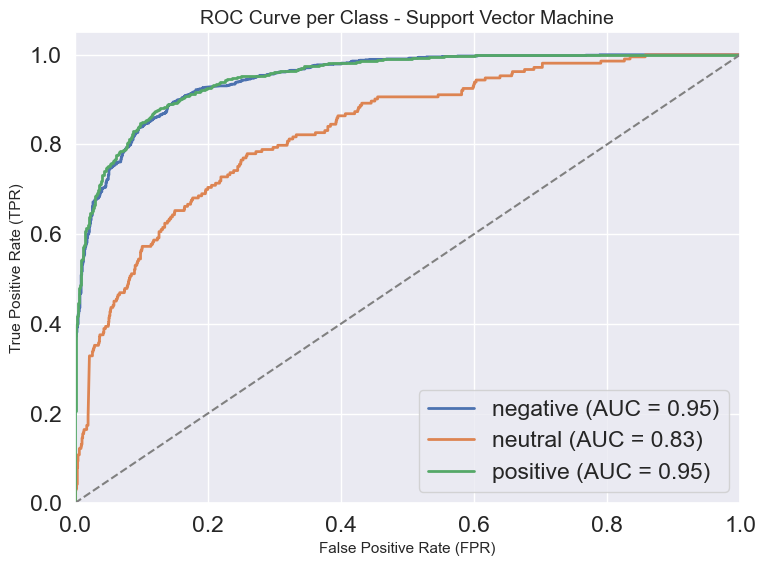

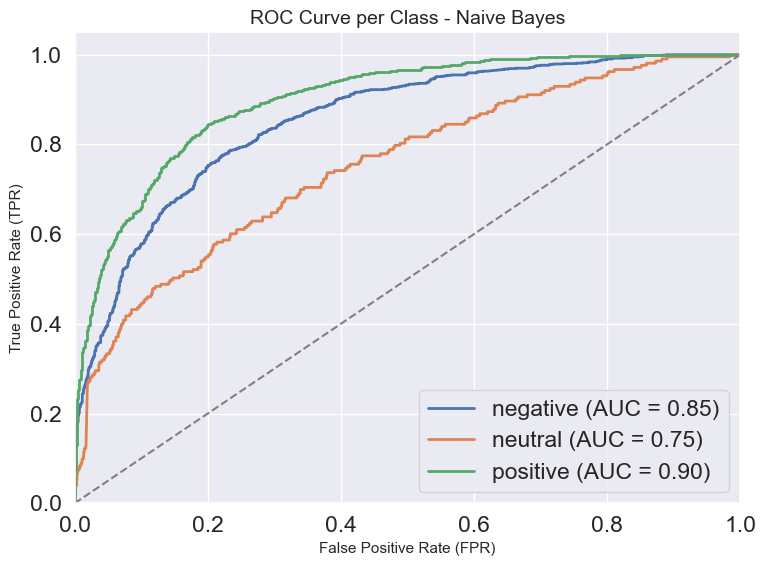

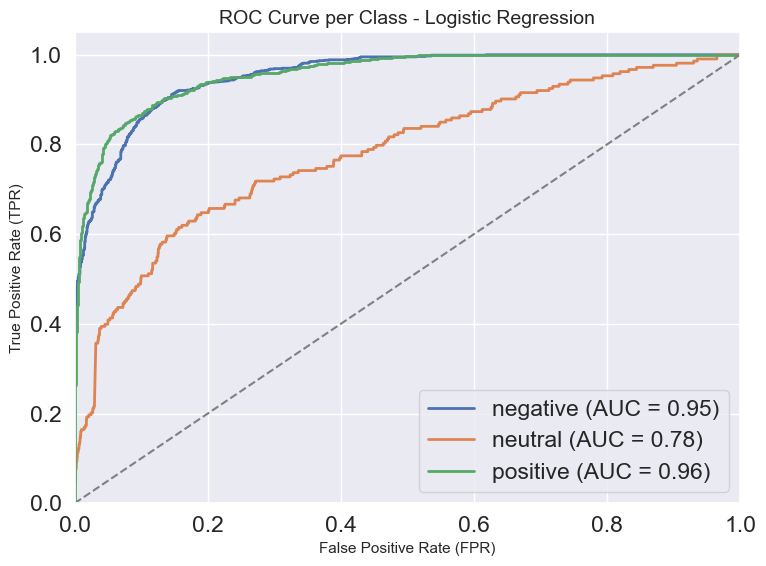

In [403]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Daftar kelas (harus sesuai urutan binarized)
class_names = ['negative', 'neutral', 'positive']
n_classes = len(class_names)

# Loop setiap model
for model_name, y_proba in score_proba.items():
    plt.figure(figsize=(8, 6))

    # Loop setiap kelas
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    # Garis acuan random guess
    plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--')

    # Konfigurasi tampilan grafik
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=11)
    plt.ylabel('True Positive Rate (TPR)', fontsize=11)
    plt.title(f'ROC Curve per Class - {model_name}', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [398]:
print(n_classes)

3


In [406]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=15)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_vec, y_train)

print(x_train_resampled.shape[0])
print(x_test.shape[0])
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_train_resampled).items()))

12909
2192
[('negative', 4303), ('neutral', 908), ('positive', 3556)]
[('negative', 4303), ('neutral', 4303), ('positive', 4303)]


In [ ]:
# Daftar model yang akan digunakan with SMOTE
models_smote = {
    "Support Vector Machine": SVC(C=1000, kernel='rbf', gamma= 1, probability=True),
    "Naive Bayes": MultinomialNB(fit_prior= True, alpha= 0.5),
    "Logistic Regression": LogisticRegression(C=100, solver='lbfgs', penalty='l2', max_iter=200)
}

classes = ['negative', 'neutral', 'positive']
y_test_binarized = label_binarize(y_test, classes=classes)

# Dictionary untuk menyimpan prediksi
predictions_smote = {}
scores_proba_smote = {}

# Loop pelatihan dan evaluasi
for model_name, model in models_smote.items():
    print(f"=== {model_name} ===")

    # Train
    model.fit(x_train_resampled, y_train_resampled)

    # Predict
    y_pred_smote = model.predict(x_test_vec)
    y_proba_smote = model.predict_proba(x_test_vec)
    
    predictions_smote[model_name] = {
        'model': model,
        'y_pred_smote': y_pred_smote
    }
    scores_proba_smote[model_name] = y_proba_smote
    # Evaluasi
    print("Accuracy:", accuracy_score(y_test, y_pred_smote))
    print("Precision:", precision_score(y_test, y_pred_smote, average='macro'))
    print("Recall:", recall_score(y_test, y_pred_smote, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred_smote, average='macro'))

    auc = roc_auc_score(y_test_binarized, y_proba_smote, average='macro', multi_class='ovr')
    print("AUC (ROC):", auc)

    print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))
    print("=" * 50, "\n")

=== Support Vector Machine ===
Accuracy: 0.8266423357664233
Precision: 0.763999665860719
Recall: 0.6936469528571925
F1 Score: 0.7134790369177129
AUC (ROC): 0.9042347516316033

Classification Report:
               precision    recall  f1-score   support

    negative       0.82      0.91      0.86      1067
     neutral       0.61      0.32      0.42       213
    positive       0.86      0.85      0.85       912

    accuracy                           0.83      2192
   macro avg       0.76      0.69      0.71      2192
weighted avg       0.82      0.83      0.82      2192


=== Naive Bayes ===
Accuracy: 0.6852189781021898
Precision: 0.576219756093249
Recall: 0.582597027298811
F1 Score: 0.5781537743707376
AUC (ROC): 0.8071014378064141

Classification Report:
               precision    recall  f1-score   support

    negative       0.76      0.74      0.75      1067
     neutral       0.24      0.30      0.26       213
    positive       0.73      0.71      0.72       912

    accuracy

In [417]:
save_dir = "saved_models_smote"
os.makedirs(save_dir, exist_ok=True)

# Simpan model ke file pickle
for model_name, data in predictions_smote.items():
    model = data['model']
    filename = f"{model_name.replace(' ', '_').lower()}_smote.pkl"
    filepath = os.path.join(save_dir, filename)

    with open(filepath, 'wb') as file:
        pickle.dump(model, file)
        
    print(f"Model SMOTE {model_name} disimpan di: {filepath}")

Model SMOTE Support Vector Machine disimpan di: saved_models_smote/support_vector_machine_smote.pkl
Model SMOTE Naive Bayes disimpan di: saved_models_smote/naive_bayes_smote.pkl
Model SMOTE Logistic Regression disimpan di: saved_models_smote/logistic_regression_smote.pkl


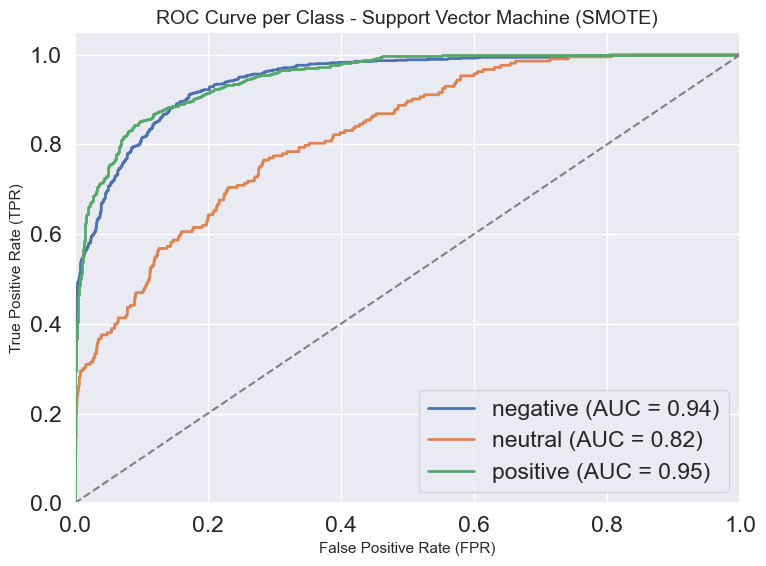

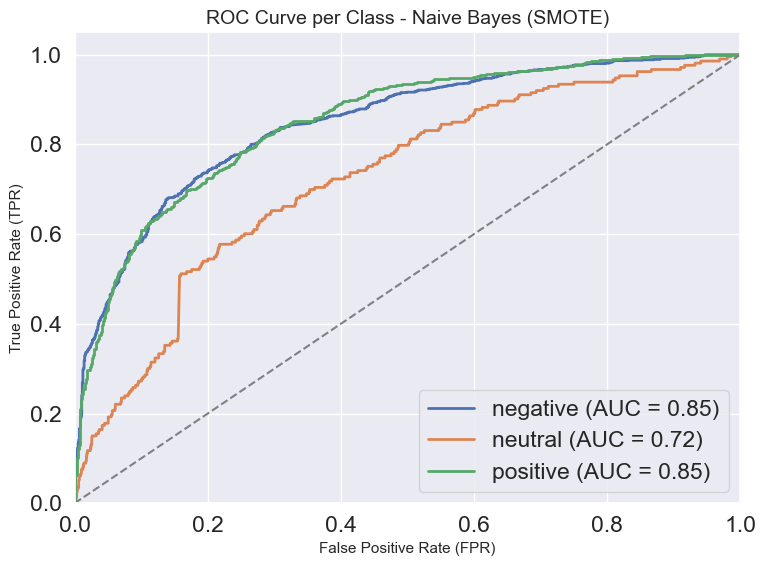

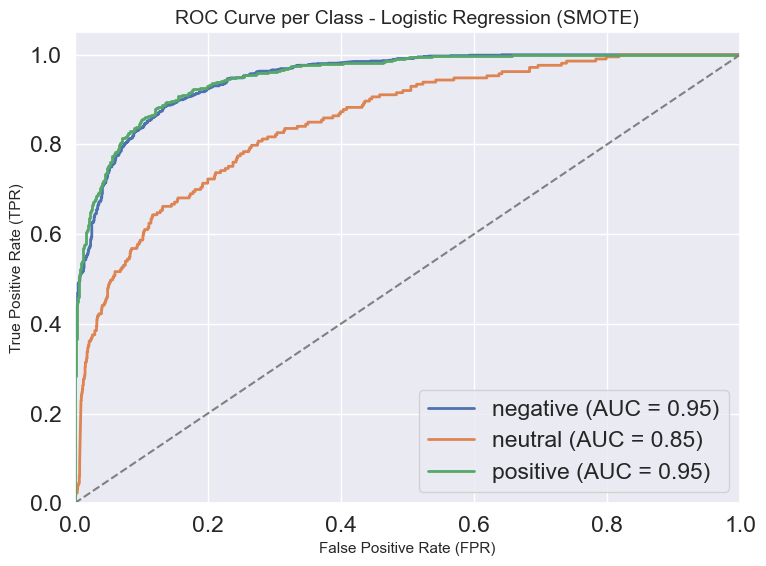

In [410]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Daftar kelas (harus sesuai urutan binarized)
class_names = ['negative', 'neutral', 'positive']
n_classes = len(class_names)

# Loop setiap model SMOTE
for model_name, y_proba in scores_proba_smote.items():
    plt.figure(figsize=(8, 6))

    # Loop setiap kelas
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    # Garis acuan random guess
    plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--')

    # Konfigurasi tampilan grafik
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=11)
    plt.ylabel('True Positive Rate (TPR)', fontsize=11)
    plt.title(f'ROC Curve per Class - {model_name} (SMOTE)', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


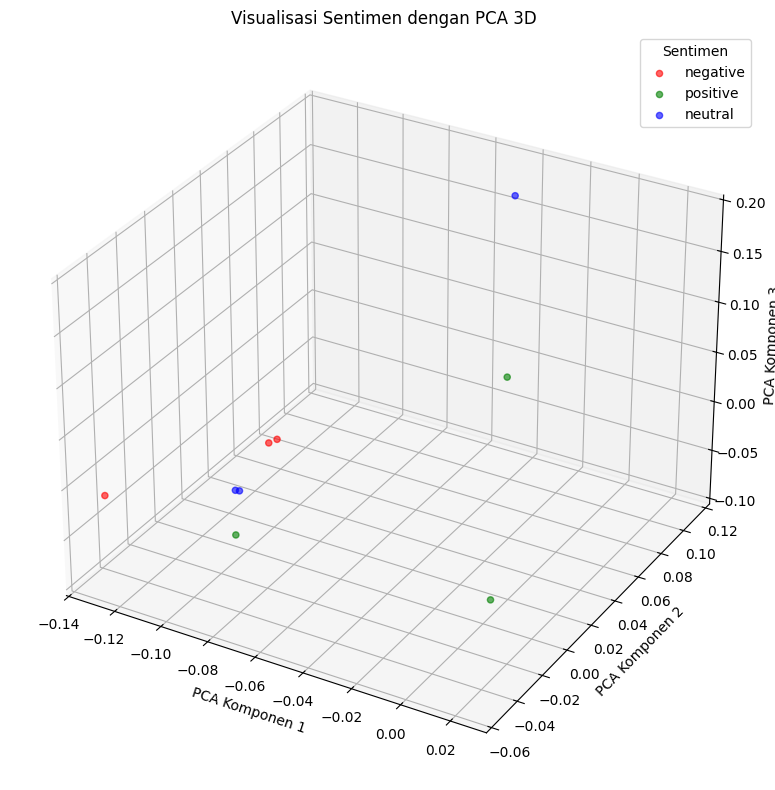

In [257]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd

# Lakukan PCA ke 3 komponen
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(x_train_vec)  # X adalah fitur (TF-IDF, CountVectorizer, dll)

# Buat DataFrame untuk visualisasi
df_pca_3d = pd.DataFrame({
    'PCA1': X_pca_3d[:, 0],
    'PCA2': X_pca_3d[:, 1],
    'PCA3': X_pca_3d[:, 2],
    'Sentimen': y_train  # y = label string: 'positive', 'negative', 'neutral'
})

colors = {'negative': 'red', 'positive': 'green', 'neutral': 'blue'}

# Plot 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Loop per label
for sentiment in ['negative', 'positive', 'neutral']:
    subset = df_pca_3d[df_pca_3d['Sentimen'] == sentiment].head(3)  # batasi 10 data
    ax.scatter(subset['PCA1'], subset['PCA2'], subset['PCA3'],
               c=colors[sentiment], label=sentiment, alpha=0.6, s=20)

# Label dan layout
ax.set_title('Visualisasi Sentimen dengan PCA 3D')
ax.set_xlabel('PCA Komponen 1')
ax.set_ylabel('PCA Komponen 2')
ax.set_zlabel('PCA Komponen 3')
ax.legend(title='Sentimen')
plt.tight_layout()
plt.show()


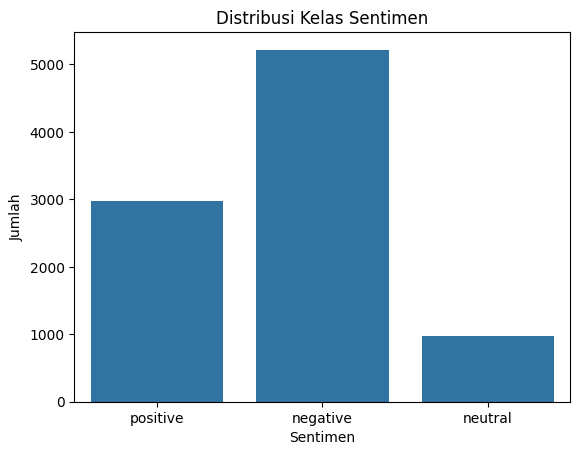

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_train)
plt.title("Distribusi Kelas Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.show()


EVALUASI

In [363]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [364]:
data_negatif = df[df['polarity'] == 'negative']
data_positif = df[df['polarity'] == 'positive']
data_netral = df[df['polarity'] == 'neutral']

SVC(C=1000, gamma=0.001, probability=True)
Confusion Matrix: Support Vector Machine


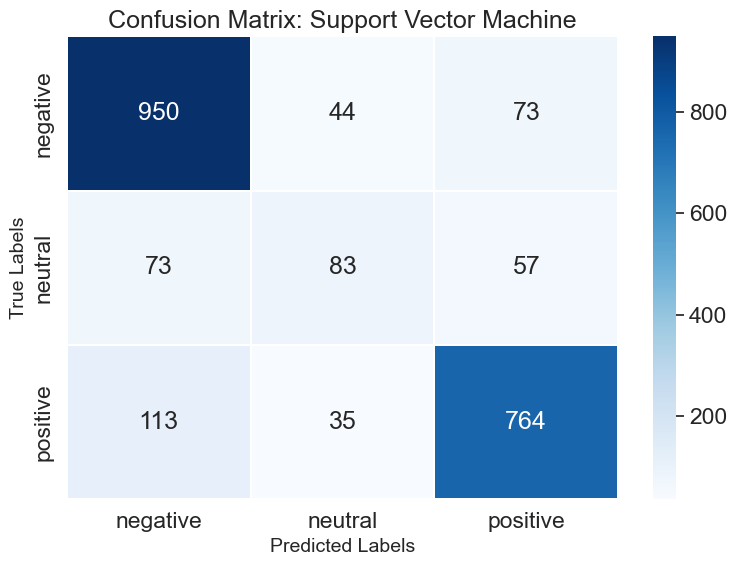

MultinomialNB(alpha=5, fit_prior=False)
Confusion Matrix: Naive Bayes


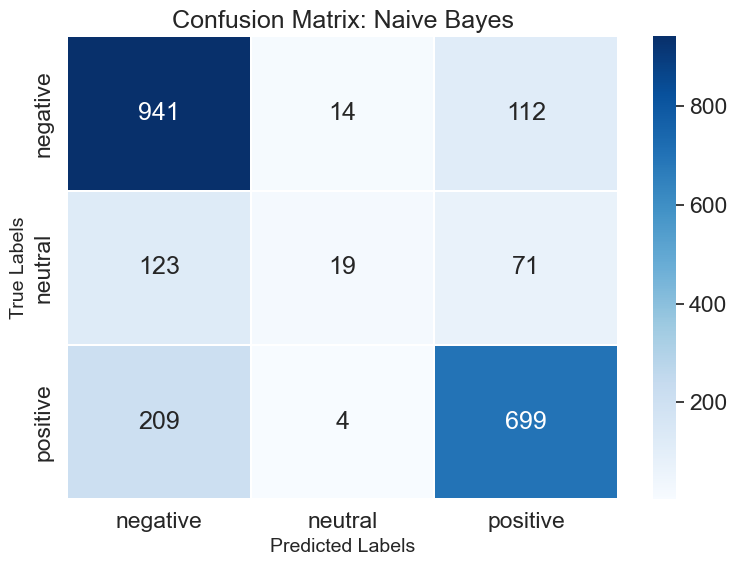

LogisticRegression(C=10, max_iter=200, solver='liblinear')
Confusion Matrix: Logistic Regression


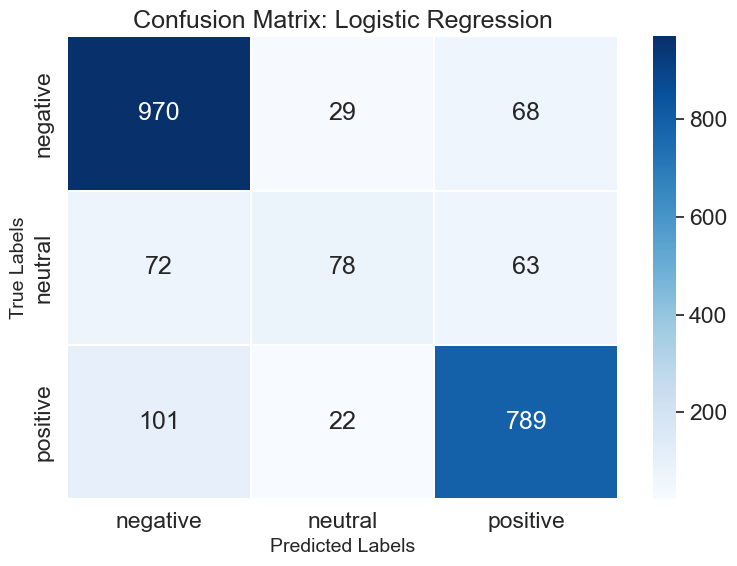

In [415]:
 # Confusion Matrix
for model_name, data in predictions.items():
    print(data['model'])
    model = data['model']
    y_pred = data['y_pred']

    print(f"Confusion Matrix: {model_name}")

    # Ambil label
    if hasattr(model, 'classes_'):
        labels = model.classes_
    else:
        labels = sorted(list(set(y_test)))

    # Hitung confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    # Visualisasi dengan resolusi dan font lebih besar
    plt.figure(figsize=(8, 6))  # Ukuran gambar lebih besar
    sns.set(font_scale=1.5)      # Ukuran font lebih besar
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, linewidths=0.1)
    plt.title(f'Confusion Matrix: {model_name}', fontsize=18)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.tight_layout()
    plt.show()

Confusion Matrix SMOTE: Support Vector Machine


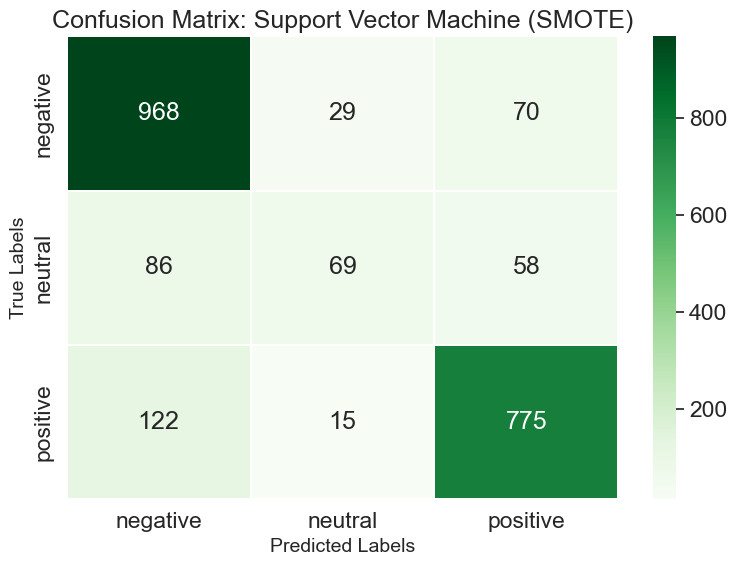

Confusion Matrix SMOTE: Naive Bayes


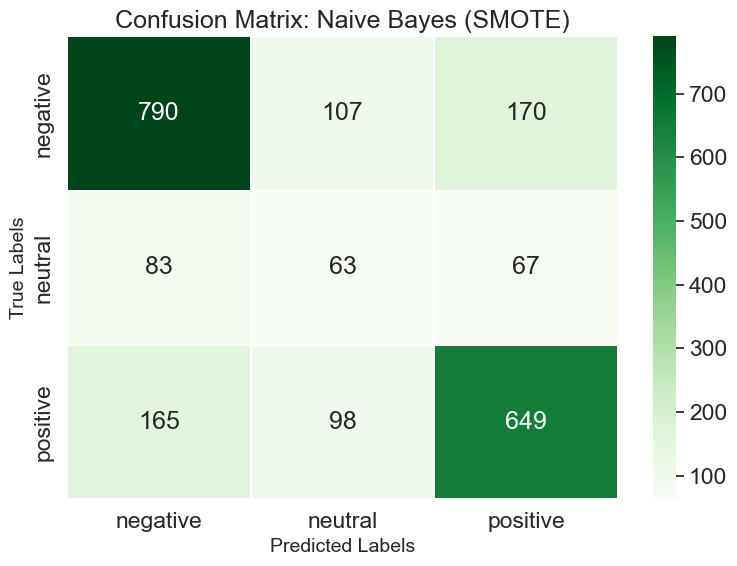

Confusion Matrix SMOTE: Logistic Regression


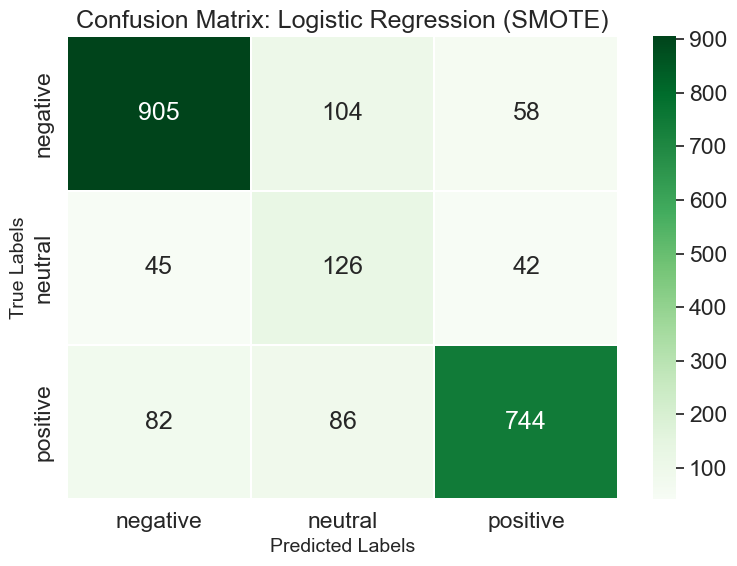

In [414]:
 # Confusion Matrix SMOTE
for model_name, data in predictions_smote.items():
    model = data['model']
    y_pred_smote = data['y_pred_smote']

    print(f"Confusion Matrix SMOTE: {model_name}")

    # Ambil label
    if hasattr(model, 'classes_'):
        labels = model.classes_
    else:
        labels = sorted(list(set(y_test)))

    # Hitung confusion matrix
    cm_smote = confusion_matrix(y_test, y_pred_smote, labels=labels)

    # Visualisasi
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.5)
    sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens',
                xticklabels=labels, yticklabels=labels, linewidths=0.1)
    plt.title(f'Confusion Matrix: {model_name} (SMOTE)', fontsize=18)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.tight_layout()
    plt.show()


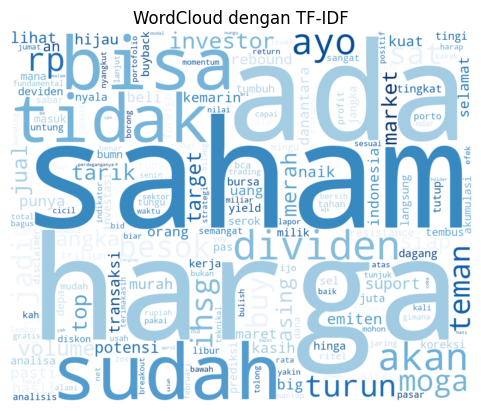

In [433]:
tfidf_vectorizer_vis = TfidfVectorizer()
X_vis = tfidf_vectorizer_vis.fit_transform(data_positif['TextStemming'])

# Dapatkan bobot TF-IDF per kata
tfidf_weights = X_vis.sum(axis=0).A1
vocab = tfidf_vectorizer_vis.get_feature_names_out()
word_weights = dict(zip(vocab, tfidf_weights))

# WordCloud berdasarkan bobot
wordcloud = WordCloud(
    width=1000,
    height=800,
    background_color='white',
    colormap='Blues'
).generate_from_frequencies(word_weights)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud dengan TF-IDF")
plt.show()

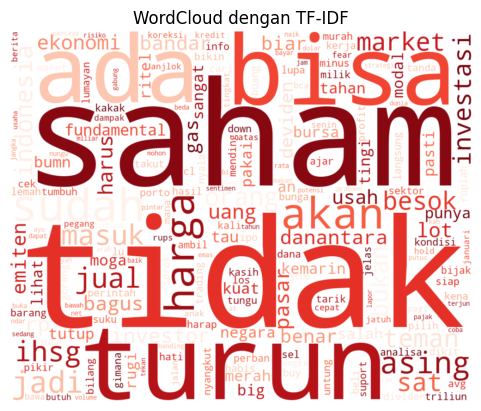

In [434]:
tfidf_vectorizer_vis = TfidfVectorizer()
X_vis_neg = tfidf_vectorizer_vis.fit_transform(data_negatif['TextStemming'])

# Dapatkan bobot TF-IDF per kata
tfidf_weights_neg = X_vis_neg.sum(axis=0).A1
vocab_neg = tfidf_vectorizer_vis.get_feature_names_out()
word_weights_neg = dict(zip(vocab_neg, tfidf_weights_neg))

# WordCloud berdasarkan bobot
wordcloud_neg = WordCloud(
    width=1000,
    height=800,
    background_color='white',
    colormap='Reds'
).generate_from_frequencies(word_weights_neg)

plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud dengan TF-IDF")
plt.show()

In [345]:
trained_models = {}
predictions_models = {}

In [346]:
# === Support Vector Machine ===
model_name_svm = "Support Vector Machine"
model_svm = SVC(C=100, kernel='rbf', gamma= 0.1, probability=True)

print(f"=== {model_name_svm} ===")

# Train
model_svm.fit(x_train_vec, y_train)

# Predict
y_pred_svm = model_svm.predict(x_test_vec)
predictions_models[model_name_svm] = {
    'model': model_svm,
    'y_pred': y_pred_svm
}
trained_models[model_name_svm] = model_svm # Simpan model yang sudah terlatih

# Evaluasi
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, average='micro'))
print("Recall:", recall_score(y_test, y_pred_svm, average='micro'))
print("F1 Score:", f1_score(y_test, y_pred_svm, average='micro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))
print("=" * 50, "\n")

=== Support Vector Machine ===
Accuracy: 0.8147810218978102
Precision: 0.8147810218978102
Recall: 0.8147810218978102
F1 Score: 0.8147810218978102

Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.87      0.86      1093
     neutral       0.46      0.46      0.46       225
    positive       0.85      0.84      0.84       874

    accuracy                           0.81      2192
   macro avg       0.72      0.72      0.72      2192
weighted avg       0.81      0.81      0.81      2192




In [347]:
def predict_sentiment2(text):
    # 1. Clean text
    text = re.sub('[^a-zA-Z]', ' ', text)  # Hanya huruf
    text = text.lower()
    tokens = text.split()

    # 2. Normalisasi slang word
    tokens = normalisasi_kata(tokens)
    

    # 3. Stopwords removal dan stemming
    tokens = [stemmer.stem(word) for word in tokens if word not in listStopwords]

    # 4. Gabungkan kembali jadi string
    cleaned_text = ' '.join(tokens)

    # 5. Vektorisasi
    vectorized_text = vectorizer.transform([cleaned_text])

    # 6. Prediksi oleh ketiga model
    pred_svm = model_svm.predict(vectorized_text)[0]
    # pred_nb = model_nb.predict(vectorized_text)[0]
    # pred_lr = model_lr.predict(vectorized_text)[0]

    # 7. Format hasil
    result = []
    result.append(f"SVM : {pred_svm.capitalize()}")
    # result.append(f"NB : {pred_nb.capitalize()}")
    # result.append(f"LR : {pred_lr.capitalize()}")

    return '\n'.join(result)

In [348]:
print(predict_sentiment2("Saham BBRI hari ini naik terus, cuan banget!"))
print(predict_sentiment2("Market sedang bullish, portofolio hijau semua."))
print(predict_sentiment2("Laba emiten naik signifikan, prospeknya bagus."))
print(predict_sentiment2("IHSG menguat sejak pagi, sentimen positif."))
print(predict_sentiment2("Saham TLKM rebound dan siap uptrend."))

print(predict_sentiment2("$BBRI antam di gerek akan di gerek BBRI di gorok"))

print("=" * 50, "\n")

print(predict_sentiment2("Saham saya nyangkut sejak minggu lalu."))
print(predict_sentiment2("IHSG anjlok parah karena sentimen global."))
print(predict_sentiment2("Portofolio merah semua, rugi besar hari ini."))
print(predict_sentiment2("Market sedang bearish, susah cari cuan."))
print(predict_sentiment2("Emiten gagal bayar dividen, mengecewakan."))

print("=" * 50, "\n")

print(predict_sentiment2("Volume transaksi saham hari ini meningkat."))
print(predict_sentiment2("IHSG ditutup di level 6.900 pada penutupan sesi kedua."))
print(predict_sentiment2("Dividen akan dibagikan pada bulan depan."))
print(predict_sentiment2("Investor asing mencatatkan net buy sebesar 50 miliar."))
print(predict_sentiment2("Perusahaan mengumumkan laporan keuangan kuartal kedua."))


SVM : Negative
SVM : Positive
SVM : Positive
SVM : Negative
SVM : Positive
SVM : Neutral

SVM : Negative
SVM : Negative
SVM : Negative
SVM : Negative
SVM : Negative

SVM : Positive
SVM : Negative
SVM : Positive
SVM : Positive
SVM : Positive
